In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
test_df = pd.read_csv("data/MERGED2021_22_PP.csv",low_memory=False)


In [3]:
select_columns = test_df[["UNITID", "INSTNM", "CONTROL", "OPENADMP", 
                          "ADM_RATE", "ADM_RATE_ALL", "COSTT4_A", "COSTT4_P"]]
select_columns.head(5)


,UNITID,INSTNM,CONTROL,OPENADMP,ADM_RATE,ADM_RATE_ALL,COSTT4_A,COSTT4_P
0,100654,Alabama A & M University,1,2.0,0.7160,0.716006,21924.0,NaN
1,100663,University of Alabama at Birmingham,1,2.0,0.8854,0.885352,26248.0,NaN
2,100690,Amridge University,2,1.0,NaN,NaN,NaN,NaN
3,100706,University of Alabama in Huntsville,1,2.0,0.7367,0.736724,24869.0,NaN
4,100724,Alabama State University,1,2.0,0.9799,0.979913,21938.0,NaN


In [4]:
# verifying that if there are null values for admission rate then it is a open adm college
indexadm = select_columns[ (select_columns['ADM_RATE'] == 'NaN') & (select_columns['ADM_RATE_ALL'] == 'NaN') & 
                          (select_columns['OPENADMP'] == 2.0) & (select_columns['OPENADMP'] == 3.0) ].index
adm_df = select_columns.drop(indexadm)
adm_df.head(5)


,UNITID,INSTNM,CONTROL,OPENADMP,ADM_RATE,ADM_RATE_ALL,COSTT4_A,COSTT4_P
0,100654,Alabama A & M University,1,2.0,0.7160,0.716006,21924.0,NaN
1,100663,University of Alabama at Birmingham,1,2.0,0.8854,0.885352,26248.0,NaN
2,100690,Amridge University,2,1.0,NaN,NaN,NaN,NaN
3,100706,University of Alabama in Huntsville,1,2.0,0.7367,0.736724,24869.0,NaN
4,100724,Alabama State University,1,2.0,0.9799,0.979913,21938.0,NaN


In [5]:
# merging cost and admission columns
clean_df = adm_df .dropna(subset=['COSTT4_A', 'COSTT4_P'], how='all')
clean_df["cost_merged"] = clean_df["COSTT4_A"].combine_first(clean_df["COSTT4_P"])
clean_df["adm_merged"] = clean_df["ADM_RATE"].combine_first(clean_df["ADM_RATE_ALL"])
clean_df.head(5)


,UNITID,INSTNM,CONTROL,OPENADMP,ADM_RATE,ADM_RATE_ALL,COSTT4_A,COSTT4_P,cost_merged,adm_merged
0,100654,Alabama A & M University,1,2.0,0.7160,0.716006,21924.0,NaN,21924.0,0.7160
1,100663,University of Alabama at Birmingham,1,2.0,0.8854,0.885352,26248.0,NaN,26248.0,0.8854
3,100706,University of Alabama in Huntsville,1,2.0,0.7367,0.736724,24869.0,NaN,24869.0,0.7367
4,100724,Alabama State University,1,2.0,0.9799,0.979913,21938.0,NaN,21938.0,0.9799
5,100751,The University of Alabama,1,2.0,0.7890,0.789043,31050.0,NaN,31050.0,0.7890


In [6]:
#selecting only the needed columns
new_clean_df = clean_df[["UNITID", "INSTNM", "CONTROL", "OPENADMP","cost_merged" ]]
new_clean_df.head(5)

,UNITID,INSTNM,CONTROL,OPENADMP,cost_merged
0,100654,Alabama A & M University,1,2.0,21924.0
1,100663,University of Alabama at Birmingham,1,2.0,26248.0
3,100706,University of Alabama in Huntsville,1,2.0,24869.0
4,100724,Alabama State University,1,2.0,21938.0
5,100751,The University of Alabama,1,2.0,31050.0


In [7]:
# grouping by open adm to get number of colleges in open and non open
group = new_clean_df.groupby("OPENADMP")["UNITID"].count()
group_df = pd.DataFrame(group)
group_df_reset = group_df.reset_index()
group_df_reset

,OPENADMP,UNITID
0,1.0,3412
1,2.0,1883


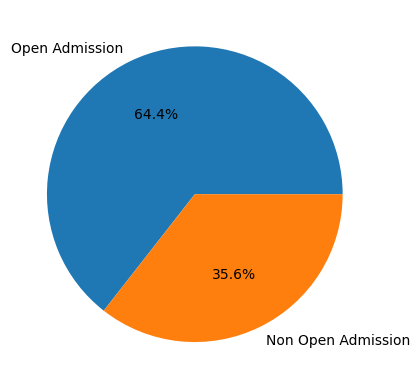

In [8]:
# displaying percentage of open vs non open colleges

labels = ["Open Admission", "Non Open Admission"]
ax = group_df_reset.plot.pie(y='UNITID', labels=labels, autopct='%1.1f%%')
ax.set_ylabel("")
ax.legend().set_visible(False)
plt.show()


## Open admission 

In [9]:
# colleges that are openadm their cost and control
open_adm = new_clean_df.loc[clean_df["OPENADMP"] ==1.0, ["UNITID", "INSTNM", "cost_merged", "CONTROL"]]
open_adm.head(5)


,UNITID,INSTNM,cost_merged,CONTROL
6,100760,Central Alabama Community College,13930.0,1
11,101028,Chattahoochee Valley Community College,9320.0,1
12,101116,South University-Montgomery,23107.0,3
13,101143,Enterprise State Community College,9454.0,1
14,101161,Coastal Alabama Community College,12881.0,1


In [10]:
# Verifying that a value can be in only one of the cost columns
#x = open_adm.loc[(open_adm["COSTT4_A"].notnull()) & (open_adm["COSTT4_P"].notnull())]


In [11]:
# group by colleges by control and average of cost for each group
mean_cost = open_adm.groupby("CONTROL")["cost_merged"].mean().round()
mean_cost_df = pd.DataFrame(mean_cost)
mean_reset = mean_cost_df.reset_index()

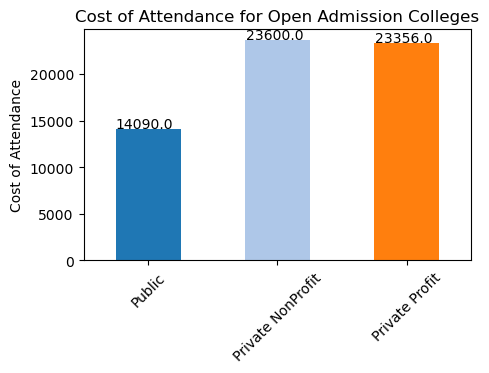

In [12]:
# displaying avg cost of open adm colleges 
# Define a colormap

num_categories = len(mean_reset['CONTROL'].unique())
ax = mean_reset.plot.bar(x= 'CONTROL', y='cost_merged', color=plt.cm.tab20(range(num_categories)), 
                         title="Cost of Attendance for Open Admission Colleges", figsize=(5,3))
new_labels = ['Public', 'Private NonProfit', 'Private Profit']
ax.set_xticklabels(new_labels, rotation=45)
ax.set_xlabel("")
ax.set_ylabel("Cost of Attendance")
ax.legend().set_visible(False)


for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

## Non Open Admission

In [13]:
# colleges that are not open admission their cost and control
non_open_adm = new_clean_df.loc[clean_df["OPENADMP"] !=1.0, ["UNITID", "INSTNM", "cost_merged", "CONTROL"]]
non_open_adm.head(5)

,UNITID,INSTNM,cost_merged,CONTROL
0,100654,Alabama A & M University,21924.0,1
1,100663,University of Alabama at Birmingham,26248.0,1
3,100706,University of Alabama in Huntsville,24869.0,1
4,100724,Alabama State University,21938.0,1
5,100751,The University of Alabama,31050.0,1


In [14]:
# group by colleges by control and average of cost for each group
non_mean_cost = non_open_adm.groupby("CONTROL")["cost_merged"].mean().round()
non_mean_cost_df = pd.DataFrame(non_mean_cost)
non_mean_reset = non_mean_cost_df.reset_index()

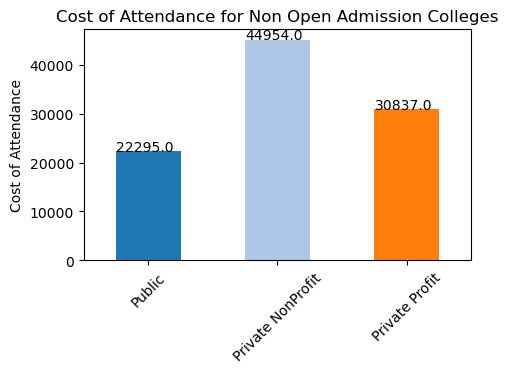

In [15]:
# displaying avg cost of open adm colleges 
non_num_categories = len(non_mean_reset['CONTROL'].unique())

ax = non_mean_reset.plot.bar(x= 'CONTROL', y='cost_merged', color=plt.cm.tab20(range(num_categories)), 
                         title="Cost of Attendance for Non Open Admission Colleges", figsize=(5,3))
non_new_labels = ['Public', 'Private NonProfit', 'Private Profit']
ax.set_xticklabels(new_labels, rotation=45)
ax.set_xlabel("")
ax.set_ylabel("Cost of Attendance")
ax.legend().set_visible(False)


for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

## Combined

In [16]:
# merging open and non open data frames

combine = new_clean_df.groupby(["OPENADMP", "CONTROL"])["cost_merged"].mean().round()
combine_df = pd.DataFrame(combine)
combine_df_reset = combine_df.reset_index()
combine_df_reset

,OPENADMP,CONTROL,cost_merged
0,1.0,1,14090.0
1,1.0,2,23600.0
2,1.0,3,23356.0
3,2.0,1,22295.0
4,2.0,2,44954.0
5,2.0,3,30837.0


In [17]:
pivot = pd.pivot_table(data=combine_df_reset, index=['CONTROL'], 
                       columns=['OPENADMP'], values='cost_merged')
pivot

OPENADMP,1.0,2.0
CONTROL,,
1,14090.0,22295.0
2,23600.0,44954.0
3,23356.0,30837.0


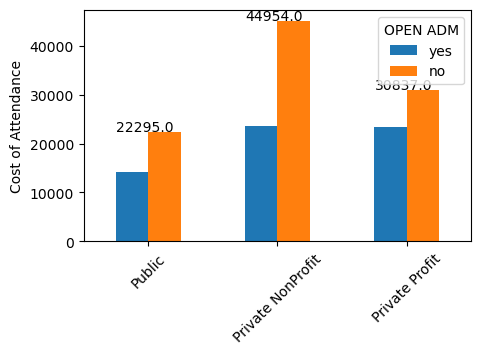

In [18]:
cb = pivot.plot( kind='bar', figsize=(5,3))
combined_labels = ['Public', 'Private NonProfit', 'Private Profit']
cb.set_xticklabels(combined_labels, rotation=45)
cb.set_xlabel("")
cb.set_ylabel("Cost of Attendance")
plt.legend(["yes", "no"], title="OPEN ADM")
for p in ax.patches:
    cb.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
